In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("predict_tradeflow.csv").set_index('Identifier')

In [3]:
df["tradeflow_change"].mean()

32.636744212001545

In [6]:
columns = ['All WTO', 'Cross Regional', 'Total articles', 'Total words',
       'Number of unique words', 'Niceness',
       'contig', 'dist', 'comlang_off', 'comlang_ethno', 'comcol',
       'comleg_pretrans', 'comleg_posttrans', 'col_dep_ever', 'sibling_ever',
       'gdp_o', 'gdp_d', 'Class 0',
       'Class 1', 'Class 2', 'gdp_change_o',
       'gdp_change_d', 'tradeflow_change']

In [7]:
df = df[columns]
df = df.dropna()

In [8]:
import numpy as np
df['Cross Regional'] = np.where(df['Cross Regional'] == 'Yes', 1, 0)
df['All WTO'] = np.where(df['All WTO'] == 'Yes', 1, 0)

In [25]:
from sklearn.model_selection import train_test_split
X, y = df.drop('tradeflow_change', axis = 1), df['tradeflow_change']
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [26]:
feature_names = X.columns

In [27]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(n_estimators = 50, max_features = 'sqrt', max_depth = 5, min_samples_leaf=1).fit(X_train,y_train)

In [28]:
r2_train = regr.score(X_train, y_train)
r2_test = regr.score(X_test, y_test)
print(r2_train, r2_test)

0.7895691005261901 0.3389213719818488


In [29]:
importances = regr.feature_importances_
std = np.std([tree.feature_importances_ for tree in regr.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)

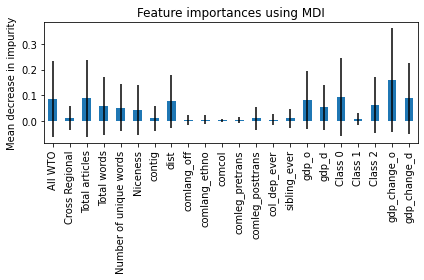

In [30]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [31]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    regr, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
forest_importances = pd.Series(result.importances_mean, index=feature_names)

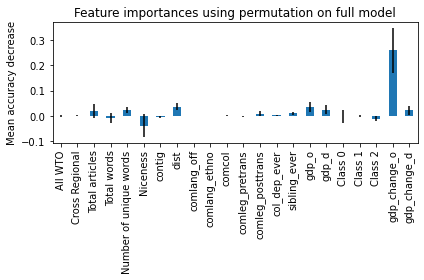

In [32]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [33]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(regr)
shap_values = explainer.shap_values(X_train)

In [34]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

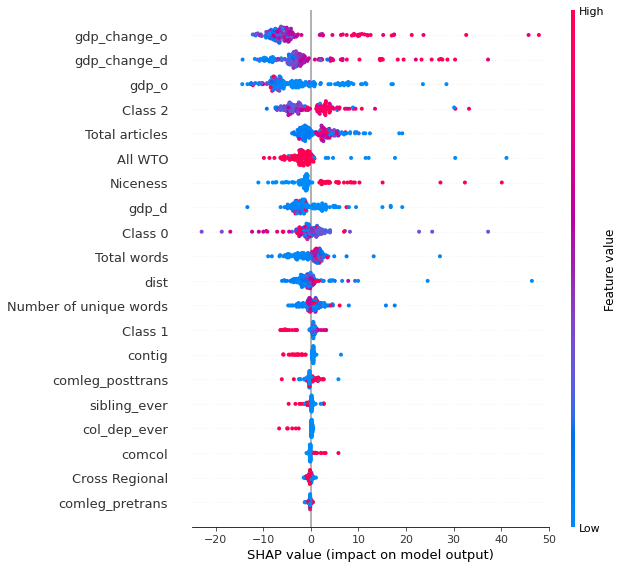

In [35]:
plt.xlim(-25,50)
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns)

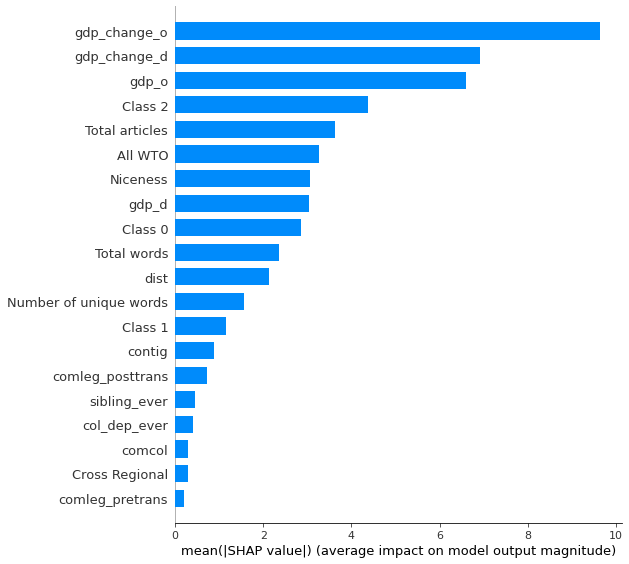

In [36]:
shap.summary_plot(shap_values, X_train, plot_type="bar")